# Autoencoder on Stock Market Data
### Dan Schmidt's Script Fall 2016

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from IPython.core.debugger import Tracer
import scipy as sp
import scipy.sparse 
import scipy.sparse.linalg
from sklearn.decomposition import PCA
from sklearn import cluster
%matplotlib inline

In [4]:
def get_symbol(symbol, start_date=None, end_date=None, daily=False):
    pickle_file = data_loc+symbol+'\\'+symbol+'.pkl'
    if os.path.isfile(pickle_file):
        print("Reading", symbol, "from pickle")
        df = pd.read_pickle(pickle_file)
    else:
        try:
            df = pd.read_csv(data_loc+symbol+'\\'+symbol+'.txt', dtype={'Time': object})
        except:
            print("failed to read in ",symbol)
            return None
        
    # Make a nice date time column
    #df['timestamp'] = df.apply(lambda x: pd.to_datetime(x['Date']+" "+x['Time'][:2]+':'+x['Time'][2:]), axis=1)
    if not os.path.isfile(pickle_file):
        df['timestamp'] = pd.to_datetime(df['Date']+" "+ df['Time'], format="%m/%d/%Y %H%M")
        df.set_index('timestamp', drop=False, inplace=True)
        df.drop(['Date', 'Time'], axis=1, inplace=True)
        print("Dumping", symbol, "to pickle")
        df.to_pickle(pickle_file)
    
    if start_date and end_date:
        return df[( (df['timestamp'] >= pd.to_datetime(start_date)) & (df['timestamp'] <= pd.to_datetime(end_date)))]
    else:
        return df

### Preprocessing
Read the data in, convert dates to a useful format, and dump it back out for faster hard drive reads later

Reading AAPL from pickle


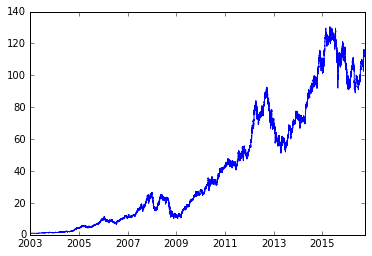

In [5]:
data_loc = "C:\\Users\\Dan\\Documents\\mldata\\market_data\\"
# read in a symbols file, in this case rough SP500 sorted by 

#store = pd.HDFStore(data_loc+'market_data.h5')

# for now, just play with AAPL
aapl = get_symbol('AAPL')

plt.plot(aapl['timestamp'], aapl['Open'])
plt.show()

def window_stack(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0,width) )

# Filter a price file by missing minutes
def day_filter(df, missing_minutes=10):
    gb = df.groupby(df.timestamp.dt.date).filter(lambda x: len(x) > 390-missing_minutes)
    return gb.fillna(method='ffill', axis=0)

def train_autoencoder(sym, start_date, end_date):
    df = sym[(sym.timestamp > start_date) & (sym.timestamp < end_date) ]
    df = day_filter(df)
    
    



   ### The functions for training out RBM model

In [29]:
aapl2014 = aapl[ (aapl.timestamp > '01/01/2015') & (aapl.timestamp < '12/31/2015') ]
gb = aapl2014.groupby(aapl2014.timestamp.dt.date).filter(lambda x: len(x) > 380)
ex = aapl2014.groupby(aapl2014.timestamp.dt.date).filter(lambda x: len(x) <= 380)
print(len(aapl2014))
print(len(gb))
print(ex)

97530
97110
                       Open    High     Low   Close  Volume  \
timestamp                                                     
2015-11-27 09:30:00  116.16  116.43  116.15  116.28  473166   
2015-11-27 09:31:00  116.25  116.32  116.08  116.08  102458   
2015-11-27 09:32:00  116.09  116.29  116.03  116.24  123966   
2015-11-27 09:33:00  116.22  116.30  116.19  116.24   53853   
2015-11-27 09:34:00  116.23  116.25  116.08  116.08   59787   
2015-11-27 09:35:00  116.07  116.16  116.00  116.03  112703   
2015-11-27 09:36:00  116.01  116.09  115.88  115.91  118111   
2015-11-27 09:37:00  115.90  115.94  115.82  115.93  101317   
2015-11-27 09:38:00  115.93  115.93  115.72  115.86  123185   
2015-11-27 09:39:00  115.86  115.92  115.78  115.85   69195   
2015-11-27 09:40:00  115.84  115.99  115.82  115.87   80359   
2015-11-27 09:41:00  115.87  115.87  115.69  115.74   85926   
2015-11-27 09:42:00  115.76  115.93  115.76  115.84   82256   
2015-11-27 09:43:00  115.84  115.87  115.75

### Run SVD on time series

In [18]:
store = pd.HDFStore(data_loc+'market_data.h5')

# Quick test of how fast to read in symbols
syms = store['symbol_groups/sp500']

cov = pd.DataFrame(columns=syms)
for s in syms:
    sym = store['symbols/'+s]
    sym = sym[ (sym.timestamp > '01/01/2015') & (sym.timestamp < '12/31/2015') ]
    cov[s] = sym['Open']
    
store.close()

In [20]:
cov.shape

(97525, 502)